# Model Usage 1
## Model comparison and optimization 


In [14]:
#%% Import necessary packages

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.patches as mpatches
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn import linear_model
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_validate, LeaveOneOut, train_test_split
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from scipy.stats import norm

import pickle 
# Set matplotlib parameters for plotting
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['axes.linewidth'] = 1.5
matplotlib.rcParams['xtick.major.size'] = 8
matplotlib.rcParams['xtick.major.width'] = 2
matplotlib.rcParams['ytick.major.size'] = 8
matplotlib.rcParams['ytick.major.width'] = 2
matplotlib.rcParams['figure.dpi'] = 100.


## 1. Save the previously trained models

The models can be saved in a pickle file, a Python specific compact binary format.
Add the following lines to `data_driven_modeling_3.ipynb` at the end.

```
import pickle
model_objects = [ols, lm_ridge, lasso, ela,  pca, regr, pls]
pickle.dump(models_object, open('models.p', 'wb'))
```


## 2. Import the trained models

In [25]:

# Import the previously trained models
model_objects = pickle.load(open('models.p', 'rb'))

# The correponding names of the models
model_names = ['OLS', 'Ridge', 'LASSO', 'Elastic Net', 'PCA', 'PCR', 'PLS']

# Exclude PCA since it is not a regression method
regression_models_names = ['OLS', 'Ridge', 'LASSO', 'Elastic Net', 'PCR', 'PLS']

# Inspect the model objects
for model_i, name_i in zip(model_objects, model_names): 
    print(name_i)
    print(model_i)

OLS
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Ridge
Ridge(alpha=41.04180502904709, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
LASSO
Lasso(alpha=0.0024253227417603556, copy_X=True, fit_intercept=True,
      max_iter=10000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
Elastic Net
ElasticNet(alpha=0.0025516060737271863, copy_X=True, fit_intercept=True,
           l1_ratio=0.5, max_iter=1000, normalize=False, positive=False,
           precompute=False, random_state=None, selection='cyclic', tol=0.0001,
           warm_start=False)
PCA
PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)
PCR
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
PLS
PLSRegression(copy=True, max_iter=500, n_components=4, scale

## 3. Preprocessing the dataset 

In [16]:
# fetch the housing dataset
dataset = fetch_california_housing()

# extract the features X and reponse y 
X_full, y_full = dataset.data, dataset.target

# print out the feature names
X_names = dataset.feature_names
print(X_names)
y_name = 'Housing Price' 

# Preprocess the data 
# Standardize 
scaler = StandardScaler().fit(X_full)
Xs = scaler.transform(X_full)

# Assign Xs to X
X = Xs.copy()
y = y_full.copy()


# 10 fold cross validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# check train and test set sizes
print(X_train.shape)
print(X_test.shape)


['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
(16512, 8)
(4128, 8)


## 4. Create helper functions 
- Parity plot (must be square)
- Error distribution



In [17]:
def parity_plot(yobj, ypred, model_name): 
    
    '''
    #plot parity plot
    '''
    
    plt.figure(figsize=(6,6))
    
    fig, ax = plt.subplots()
    ax.scatter(yobj, ypred,s = 30, alpha = 0.5)
    
    plt.xlabel("Ground Truth")
    plt.ylabel("Model prediction")
    
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect('equal', 'box')
    plt.title(r'{}'.format(model_name))
    plt.tight_layout()

def error_distribution(yobj, ypred, model_name):
    
    '''
    Plot the error distribution
    return the standard deviation of the error distribution
    '''
    if len(ypred.shape) > 1:
        ypred = ypred[:,0]
    fig, ax = plt.subplots(figsize=(6,6))
    ax.hist(yobj - ypred, density=1, bins = 20, alpha=0.5, color='steelblue')
    mu = 0
    sigma = np.std(yobj - ypred)
    x_resid = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    ax.plot(x_resid, norm.pdf(x_resid, mu, sigma), color='r')
    ax.set_xlabel('Error')
    ax.set_ylabel('Normalized Probability Density')
    plt.title(r'{}, $\sigma$-{:.2}'.format(model_name, sigma))

## 5. Evaluate the metrics for all models
- $r^2$
- RMSE

<Figure size 600x600 with 0 Axes>

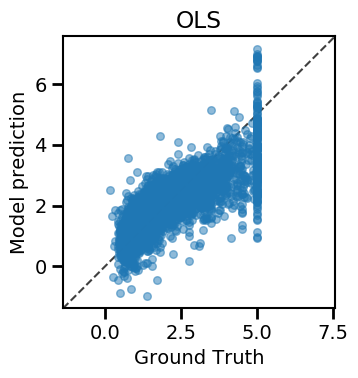

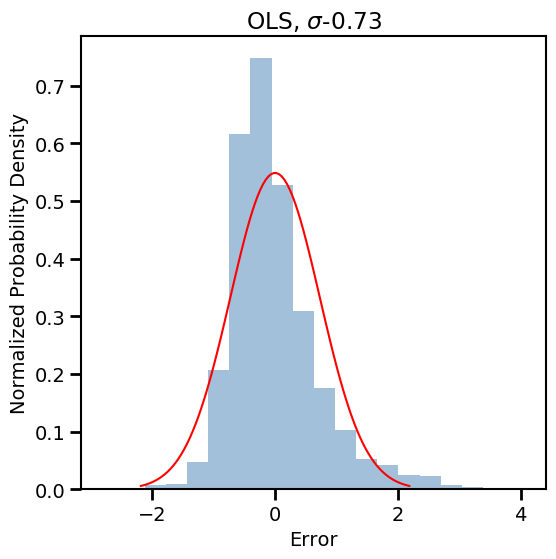

<Figure size 600x600 with 0 Axes>

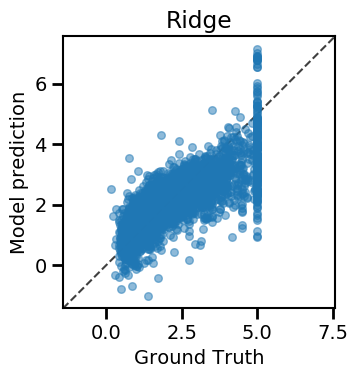

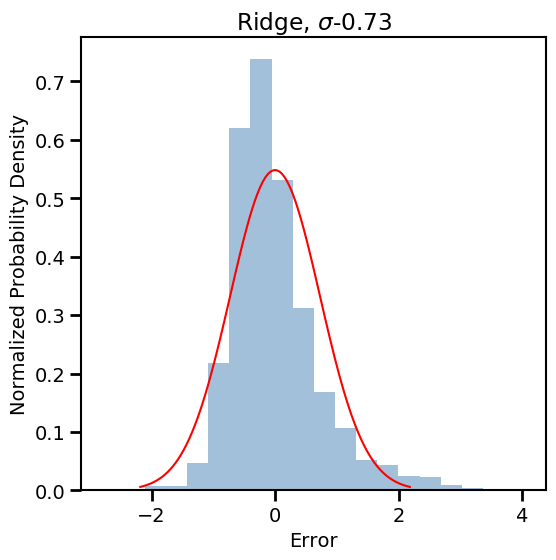

<Figure size 600x600 with 0 Axes>

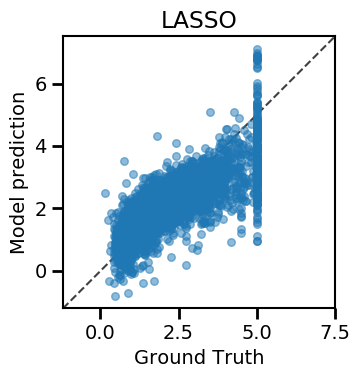

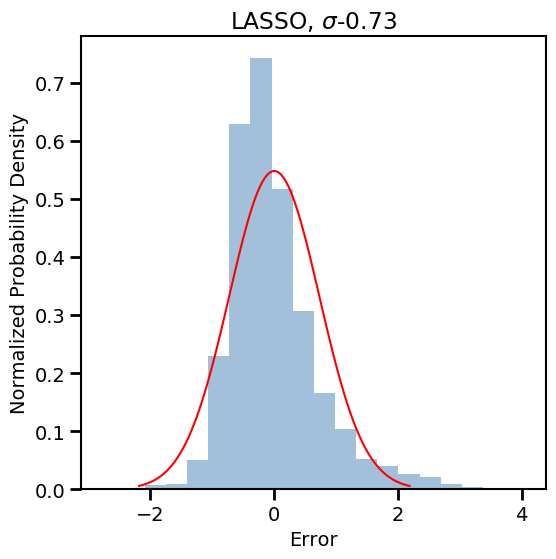

<Figure size 600x600 with 0 Axes>

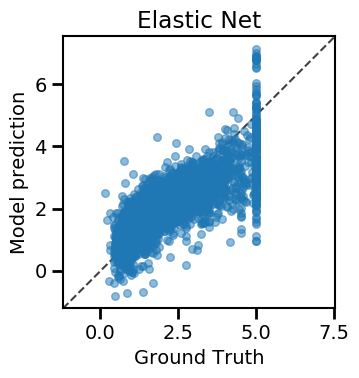

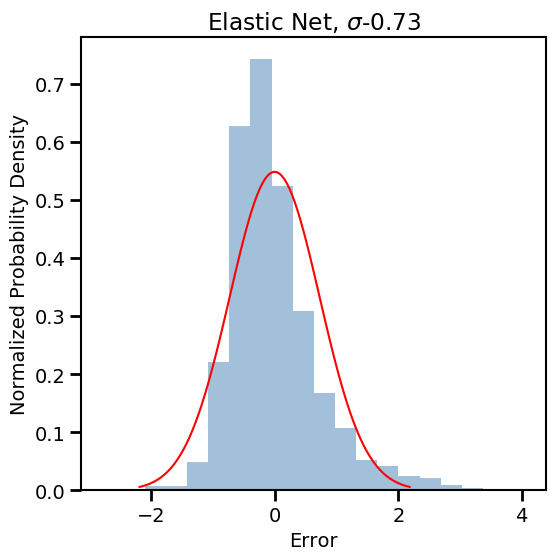

<Figure size 600x600 with 0 Axes>

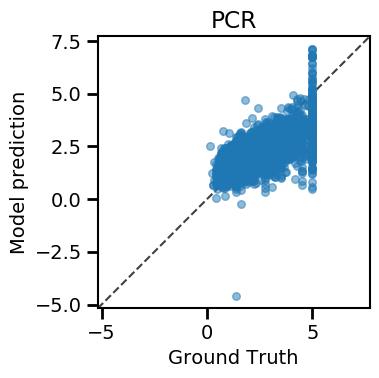

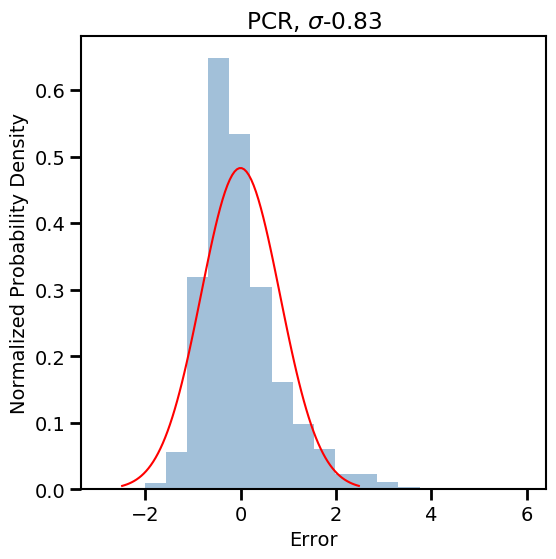

<Figure size 600x600 with 0 Axes>

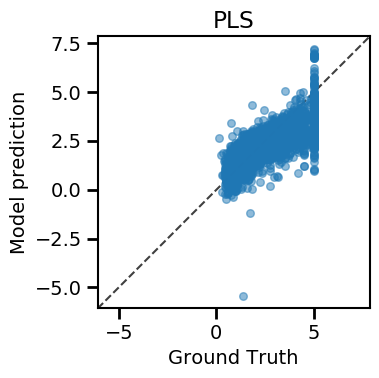

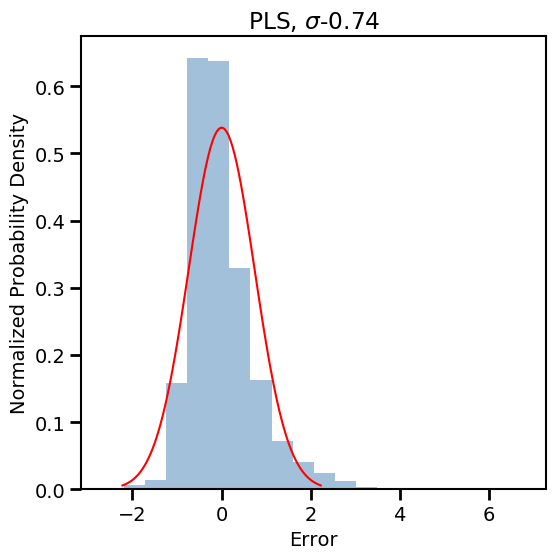

In [18]:
# Calculate the test metrics - r^2 and RMSE
r2_test = []
RMSE_test = []

for model_i, name_i in zip(model_objects, model_names):
    
    if name_i == 'PCA': # PCA is not a regression method, skip
        continue
        
    if name_i == 'PCR': # the input of PCR is PCA-transformed X  
        
        pca = model_objects[model_names.index('PCA')]
        scores_test = pca.transform(X_test)[:, :6] # choose 5 PCs
        y_pred_i = model_i.predict(scores_test)
        
    else:
        y_pred_i = model_i.predict(X_test)
    
    parity_plot(y_test, y_pred_i, name_i)
    error_distribution(y_test, y_pred_i, name_i)
    
    r2_i = r2_score(y_test, y_pred_i)
    RMSE_i = np.sqrt(mean_squared_error(y_test, y_pred_i))
    r2_test.append(r2_i)
    RMSE_test.append(RMSE_i)

# Convert metrics list into numpy array 
r2_test = np.array(r2_test)
RMSE_test = np.array(RMSE_test)



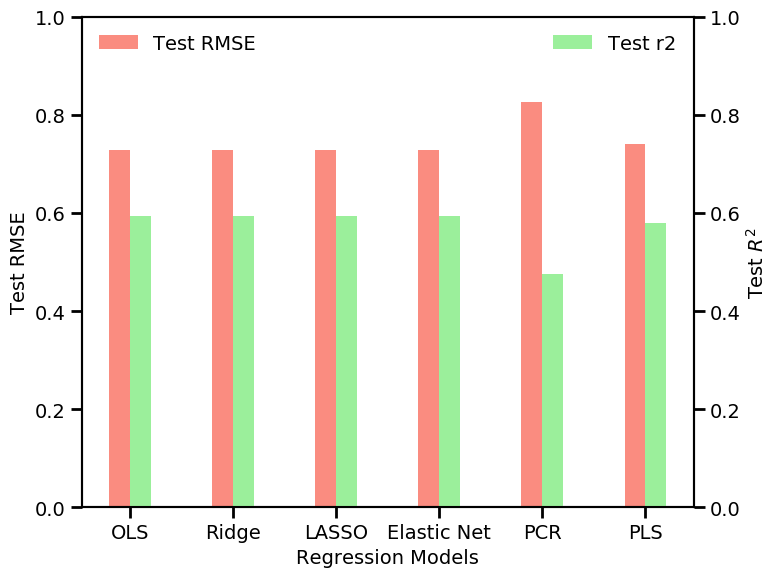

In [19]:
# Make a bar graph to compare both performance
x_pos = np.arange(len(regression_models_names))
base_line = 0.0
opacity = 0.9
bar_width = 0.2

fig, ax1 = plt.subplots(figsize=(8,6))
ax2 = ax1.twinx()
rects1 = ax1.bar(x_pos, RMSE_test - base_line, bar_width, 
                alpha = opacity, color='salmon',
                label='Test RMSE')
rects2 = ax2.bar(x_pos+bar_width, r2_test - base_line, bar_width, 
                alpha = opacity, color='lightgreen',
                label='Test r2')
ax1.set_xticks(x_pos+bar_width/2)
ax1.set_xticklabels(regression_models_names, rotation=0)
ax1.set_xlabel('Regression Models')
ax1.legend(loc= 'upper left', frameon=False)
ax2.legend(loc= 'upper right', frameon=False)

# left y axis 
ax1.set_ylabel('Test RMSE', color = 'k')
ax1.set_ylim([0, 1])
ax1.tick_params('y', colors='k')
# right y axis
ax2.set_ylabel('Test $R^2$',color = 'k')
ax2.set_ylim([0, 1])
ax2.tick_params('y', colors='k')
plt.tight_layout()



In [20]:
#Print the name of the model with lowest RMSE
print('The model with lowest RMSE - {}'.format(model_names[np.argmin(RMSE_test)]))
print('The model with highest R2 - {}'.format(model_names[np.argmax(r2_test)]))

The model with lowest RMSE - OLS
The model with highest R2 - OLS


## 6. Select the best model

In [21]:
# choose the index with lowest RMSE
index_best = np.argmin(RMSE_test)
model_best = model_objects[index_best]

## 7. Process new data points for prediction
- Method 1, write the data point directly into the notebook
- Method 2, write the data points into an excel sheet

In [22]:
# Method 1, write the data point directly into the notebook
X_new_1 = np.array([8.5, 30, 5, 1.1, 292, 2.43, 36, -110])
# Pad X_new into a 2D array if necessary
if len(X_new_1.shape) < 2:
        X_new_1 = X_new_1[np.newaxis,:]

# standardize the data using the same scaler used in training
X_new_1s = scaler.transform(X_new_1)

# predict using the best model
y_new_1_pred = model_best.predict(X_new_1s)
print(' The predict value is {0:5.2f}'.format(float(y_new_1_pred)))




 The predict value is -0.16


In [23]:
# Method 2, write the data points into an excel sheet
new_data = pd.read_excel('new_data.xlsx', index_col=None)
print(new_data.head())

# Pad X_new into a 2D array if necessary
X_new_2 = np.array(new_data)
if len(X_new_2.shape) < 2:
    X_new_2 = X_new_2[np.newaxis,:]

# standardize the data using the same scaler used in training
X_new_2s = scaler.transform(X_new_2)

# predict using the best model
y_new_2_pred = model_best.predict(X_new_2s)

# Save the prediction into a new excel sheet
new_data['predicted housing price'] = y_new_2_pred
print(new_data.head())
new_data.to_excel('new_data_v2.xlsx')

   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0       7        30       4.9        1.1         269      2.58        37   
1       8        50       4.8        1.2         265      2.13        32   
2       9        70       4.7        1.3         261      1.68        27   

   Longitude  
0       -120  
1       -110  
2       -100  
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0       7        30       4.9        1.1         269      2.58        37   
1       8        50       4.8        1.2         265      2.13        32   
2       9        70       4.7        1.3         261      1.68        27   

   Longitude  predicted housing price  
0       -120                 3.114769  
1       -110                 1.570905  
2       -100                 0.027041  
